# Исследование данных о российском кинопрокате



В данном проекте я исследую данные из двух истоников - статистика по фильмам из Кинопоиска и данные о сборах и финансовой поддержке от Министерства Культуры. 

В процессе выполнения проекта, я объединю данные из двух источников. Затем я обработаю данные - по возможности устраню пропуски и дубликаты. Далее я посмотрю на динамику проката и сборов от фильмов по годам. В заключительной части я исследую как финансовая поддержка влияет на сборы и рейтинг фильмов. 

# Шаг 1. Откройте файлы с данными и объедините их в один датафрейм. 

Объедините данные таким образом, чтобы все объекты из датасета `mkrf_movies` обязательно вошли в получившийся датафрейм. 

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_0" aria-expanded="false" aria-controls="collapseHint_0">Подсказка</button>
        </div>
        <div id="collapseHint_0" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на тип данных столбца, по которому будете соединять датафреймы. Тип данных этих столбцов должен быть одинаковым в обоих датафреймах.
            </div>
        </div>
    </div>
</div>

In [118]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import math
import seaborn as sns

In [119]:
# Загрузим данные
data_movies= pd.read_csv('/datasets/mkrf_movies.csv')
data_shows = pd.read_csv('/datasets/mkrf_shows.csv')

Выведем таблицы, чтобы посмореть на переменные.

In [120]:
# вывод
print(data_movies.head(5))
print()
print(data_shows.head(5))

                  title   puNumber           show_start_date            type  \
0      Открытый простор  221048915  2015-11-27T12:00:00.000Z  Художественный   
1  Особо важное задание  111013716  2016-09-13T12:00:00.000Z  Художественный   
2          Особо опасен  221038416  2016-10-10T12:00:00.000Z  Художественный   
3          Особо опасен  221026916  2016-06-10T12:00:00.000Z  Художественный   
4          Особо опасен  221030815  2015-07-29T12:00:00.000Z  Художественный   

                                         film_studio production_country  \
0  Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...                США   
1                              Киностудия "Мосфильм"               СССР   
2  Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...                США   
3  Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...                США   
4  Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...                США   

            director                                           produ

Буду объединять таблица по puNumber. Посмотрю вначале на типы переменных в каждой таблице.

In [121]:
# Опишу два датасета
print(data_movies.info())
print()
print(data_shows.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

Видно, что в первой таблице puNumber это переменная object, а во второй - int. Поменяю тип во второй таблице.

In [122]:
# меняю тип 
data_shows['puNumber'] = data_shows['puNumber'].astype(str)

In [123]:
# Объединяю таблицы
data = data_movies.merge(data_shows, on = 'puNumber', how = 'left')

In [124]:
# Проверяю названия колонок
data.columns

Index(['title', 'puNumber', 'show_start_date', 'type', 'film_studio',
       'production_country', 'director', 'producer', 'age_restriction',
       'refundable_support', 'nonrefundable_support', 'budget',
       'financing_source', 'ratings', 'genres', 'box_office'],
      dtype='object')

In [125]:
# Переименую puNumber
data = data.rename(columns = {'puNumber' : 'pu_number'})
data.columns

Index(['title', 'pu_number', 'show_start_date', 'type', 'film_studio',
       'production_country', 'director', 'producer', 'age_restriction',
       'refundable_support', 'nonrefundable_support', 'budget',
       'financing_source', 'ratings', 'genres', 'box_office'],
      dtype='object')

 # Шаг 2. Предобработка данных

# Шаг 2.1. Проверьте типы данных

- Проверьте типы данных в датафрейме и преобразуйте их там, где это необходимо.

In [126]:
# вывод инфо о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   pu_number              7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

In [127]:
# меняю типы
data['show_start_date'] = pd.to_datetime(data['show_start_date'], format = '%Y-%m-%dT%M:%H:%S.%fZ')

In [128]:
# смотрю на значения рейтинга
data['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '99%', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6',
       '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7',
       '4.9', '3.9', '2.7', '3.3', '2.9', '28%', '3.7', '1.4', '3.1',
       '97%', '3.5', '3.2', '2.8', '1.5', '2.1', '2.5', '9.2', '3.4',
       '1.1', '3.6', '83%', '64%', '91%', '94%', '62%', '79%', '90%',
       '19%', '88%', '1.0', '89%', '1.3', '1.9', '1.8', '1.2', '1.7',
       '9.0', '98%', '8.9', '9.1'], dtype=object)

In [129]:
# унифицирую значения рейтинга
data['ratings'] = data['ratings'].str.replace('%','')
data['ratings'] = data['ratings'].astype(float)

In [130]:
# унифицирую данные
data.loc[data['ratings']>10,'ratings'] = data.loc[data['ratings']>10, 'ratings']/10

# Шаг 2.2. Изучите пропуски в датафрейме

- Объясните, почему заполнили пропуски определённым образом или почему не стали этого делать.

In [131]:
# Вывожу пропуски
pd.DataFrame(data.isna().mean()*100).rename(columns = {0:"percent"}).style.background_gradient('coolwarm')

,percent
title,0.000000
pu_number,0.000000
show_start_date,0.000000
type,0.000000
film_studio,0.240449
production_country,0.026717
director,0.120224
producer,7.587497
age_restriction,0.000000
refundable_support,95.565055


Видно, что очень много пропусков в данных про финансы фильма, причём одинаковое число - скорее всего это связано с источником данных о финансах. Есть довольно много пропусков в данных о выручке фильмов. Среднее колличество в данных о реётинге, жанре и продюсере. И очень мало в данных о студии, стране и режиссере.

In [132]:
#столбчатая диаграмма
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 16)
            .set_title('Проценты пропусков' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

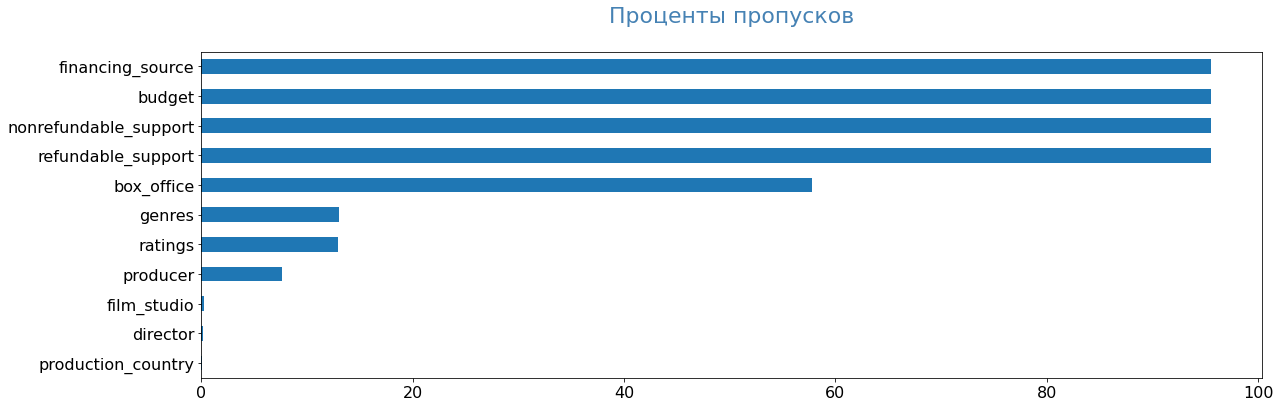

In [16]:
pass_value_barh(data)

На графике мы снова видим процент совпадений пропусков у некоторых переменных.
Для начала начнём заполнять пропуски с переменных, где их очень мало. Их насколько мало, что кажется, что можно их точечно заполнить.

In [133]:
# срез с пропусками
data.query('production_country.isna()')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09 00:12:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.2,"детский,комедия",194527.0
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 00:12:00,Художественный,NaN,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия",NaN


In [134]:
# заполню пропуски
data.loc[3186,'production_country'] = 'Россия'
data.loc[4441, 'production_country'] = 'Россия'

In [135]:
# срез
data.query('director.isna()')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
764,"Три звезды. Концерт в Waldbuhne Theater, Берли...",126003512,2012-12-04 00:12:00,Прочие,Райзинг Алтернатив,Великобритания,NaN,Вальдбюне Театр,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,44350.0
1735,Помпеи. Британский музей,126003413,2013-09-11 00:12:00,Прочие,"МортуСкрин, Британский музей",Великобритания,NaN,Британский музей,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3840,Зур концерт (Большой концерт).,217027010,2010-06-24 00:12:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4052,"Ганс Сэйфуллин ""Авылым чишмэлэре. Ганс Сэйфулл...",217017310,2010-04-22 00:12:00,Художественный,"ООО ""Барс-Рекордс""",Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4298,Изге Вэли (Святой Валентин),217020610,2010-05-20 00:12:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4415,Bon Jovi. The Circle Tour,126001710,2010-11-11 00:12:00,Прочие,Эншутц Интертейнмент Груп,США,NaN,Эншутц Интертейнмент Груп,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.9,"концерт,музыка",NaN
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 00:12:00,Художественный,NaN,Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия",NaN
4923,Георг Фридрих Гендель. Мессия. Оратория. Корол...,126001111,2011-04-25 00:12:00,Прочие,Опус Арт,Великобритания,NaN,Короевский колледж Кембриджа,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4942,Питер Гэбриэл и New Blood Orchestra 3D,126002711,2011-11-11 00:12:00,Прочие,Омниверс Визион,Великобритания,NaN,Омниверс Визион,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,6.7,"концерт,музыка",NaN


Это записи концертов, у которых действительно нет режиссера. Пропусков в названиях студий тоже довольно мало. Мы можем удалить эти записи и это не повлияет на результат анализа.

In [136]:
# удаляю наблюдения
data = data.dropna(subset = ['director', 'film_studio']).reset_index(drop = True)

Жанр является категориальной переменной, мы не сможем заполнить пропуски с помощью какого-то алгоритма, при этом пропусков достаточно много и терять так много наблюдений нельзя. Поэтому, я их просто оставлю.

In [137]:
# применяем knn для подмножества данных
d = (data.query('box_office.notna()')[['ratings', 'box_office']])
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform', metric = 'nan_euclidean')
imputer.fit(d)
dtrans = imputer.transform(d)

In [138]:
# запишем полученные значения в датафрейм
data.loc[data['box_office'].notna(), 'ratings']= (pd.DataFrame(dtrans, index = data.loc[data['box_office'].notna(), 'ratings']
                                                               .index ).loc[:,0])

Пропусков в данных о кинопрокате слишком много, мы не можем их ни заполнить на какие-то другие ни удалить, так как это сильно повлияет на наш анализ.
Посмотрим на пропуски в данных о бюджете и финансах фильма. Поскольку все эти пропуски абсолютно одинаковые (полностью совпадают), посмотрим только на примере одной переменной.

In [139]:
# срез данных с известным бюджетом
data.query('budget.notna()').groupby('production_country')['type'].count()

production_country
Россия                                        316
Россия - Грузия                                 1
Россия, Армения                                 1
Россия, Бельгия, Финляндия                      1
Россия, Германия                                2
Россия, Германия, Великобритания                1
Россия, Германия, Казахстан, Польша, Китай      1
Россия, Италия                                  2
Россия, Латвия, Чешская Республика              1
Россия, Сербия                                  1
Россия, Украина, Польша                         1
Россия, Франция, Латвия                         1
Россия-Китай                                    1
Россия-Словакия-Чехия                           1
Россия-Украина                                  1
Name: type, dtype: int64

Мы знаем данные о бюджете и финансировании только тех фильмов, в которых принимала участие Россия (потому что такой источник этих данных).

In [144]:
# срез
data.loc[data['production_country'].str.contains('Россия') & data['budget'].isna()]['type'].count()


1635

При этом есть 1635 наблюдений с фильмами с участием России, где тем не менее данные о бюджете отсутствуют. 

Посмотрю на статистики финансовой поддержки

In [145]:
# вывожу статистику
data['refundable_support'].describe().apply('{:,.0f}'.format)

count            332
mean      11,864,458
std       24,916,555
min                0
25%                0
50%                0
75%       15,000,000
max      180,000,000
Name: refundable_support, dtype: object

In [146]:
# вывожу статистику
data['nonrefundable_support'].describe().apply('{:,.0f}'.format)

count            332
mean      48,980,989
std       59,980,118
min                0
25%       25,000,000
50%       30,000,000
75%       40,375,000
max      400,000,000
Name: nonrefundable_support, dtype: object

In [147]:
# смотрим значения
data['financing_source'].unique()

array([nan, 'Министерство культуры', 'Фонд кино',
       'Министерство культуры, Фонд кино'], dtype=object)

Посмотрим, возможно, что фильмы с участием РФ, у которых есть и нету данные о финансовой поддержке разничаются по годам. Такое можно было бы предположить, если бы данные о финансировании были  бы только, начиная с какого-то года.

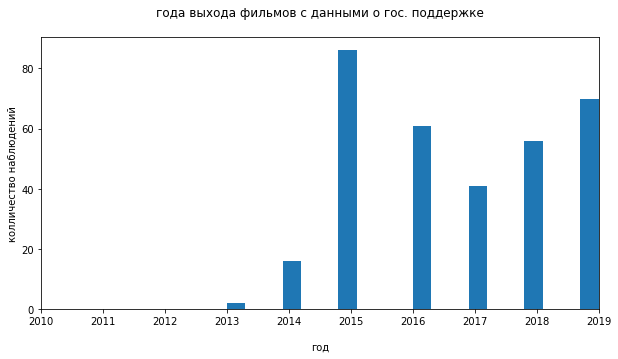

In [148]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data.query('budget.notna()')['show_start_date'].dt.year, bins = 20, rwidth = 1);
plt.xlabel('\n' 'год')
plt.ylabel('колличество наблюдений')
plt.xlim(2010, 2019)
plt.title('года выхода фильмов с данными о гос. поддержке' '\n');


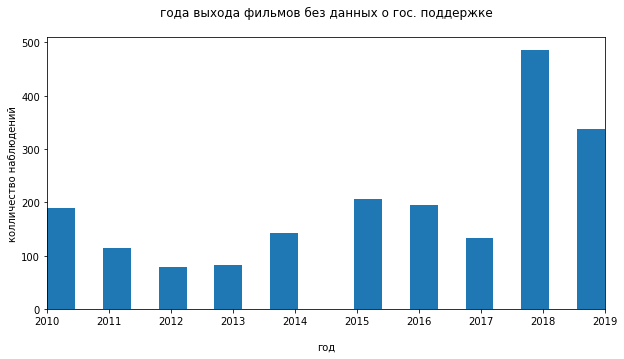

In [149]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data.loc[data['production_country'].str.contains('Россия'), 'show_start_date'].dt.year, bins = 20, rwidth = 1);
plt.xlabel('\n' 'год')
plt.ylabel('колличество наблюдений')
plt.xlim(2010, 2019)
plt.title('года выхода фильмов без данных о гос. поддержке' '\n');


Мы видим, что фильмы с данными о гос. поддержке выходили после 2013 года. Можно сделать вывод, что фильмы с участием РФ, выходившие после 2013 года и с пропусками в этих значениях не имеют гос. финансирования. Я заменю пропуски в refundable_support и nonrefundable_support в таких наблюдениях на 0.

In [150]:
# заполняю пропуски
(
    data
    .loc[(data['production_country'].str.contains('Россия')) 
         & (data['show_start_date'].dt.year>=2013) & (data['refundable_support'].isna()),'refundable_support']) = 0

(
    data
    .loc[(data['production_country'].str.contains('Россия')) 
         & (data['show_start_date'].dt.year>=2013) & (data['nonrefundable_support'].isna()),'nonrefundable_support']) = 0


# Шаг 2.3. Изучите дубликаты в датафрейме
- Проверьте, есть ли в данных дубликаты. Опишите причины, которые могли повлиять на появление дублей.

Для начала посмотрим, есть ли явные дубликаты.

In [151]:
# процент дубликатов
data.duplicated().mean()

0.0

Явных дубликатов в данных нет.

In [152]:
# дубликаты по подмножеству
data.duplicated(subset = ['title']).mean()

0.09557640750670242

Оказывается есть дубликаты по названию, удялю их.

In [153]:
# удаляю
data = data.drop_duplicates(subset = ['title']).reset_index(drop = True)

In [154]:
# уникальные значения
data['type'].unique()

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', ' Художественный', ' Анимационный',
       'Музыкально-развлекательный'], dtype=object)

Есть проблема в пробеле в начале жанра "Художественный", таким типом проблем займёмся на следующем шаге.

In [155]:
# уникальные значения
data['film_studio'].unique()

array(['Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикчерз, Тиг Продакшнз',
       'Киностудия "Мосфильм"',
       'Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Платт Продакшнз, Рилейтивити Медиа, Спайгласс Интертейнмент, Стилкин Филмз, Топ Кау Продакшнз',
       ...,
       'Дэниел Гродник Продакшнз, Вандерфилм Медиа Корпорэйшн, Импринт Интертейнмент, Вор Хорс Интертейнмент, Пимиента ',
       'Никелодеон Анимейшн Студиос, Спин Мастер',
       'Анимаккорд Лтд., ООО Студия "АНИМАККОРД"'], dtype=object)

In [156]:
# подсчёт значений
len(data['film_studio'].unique())

5441

Есть 5441 разных названий студий. На первый взгляд сложно увидеть, есть ли тут дубликаты, но из названий можно понять, что проблемы могут возникнуть либо с названиями, дублирующими строчный и заглавный текст, либо с транслитерацией английских названий.

In [157]:
# унификация шрифта
data['film_studio'] = data['film_studio'].str.lower()

In [158]:
# считаем значения
len(data['film_studio'].unique())

5402

Получилось избавиться от 39 дубликатов.

# Шаг 2.4. Изучите категориальные значения

- Посмотрите, какая общая проблема встречается почти во всех категориальных столбцах;
- Исправьте проблемные значения в поле `type`.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_1" aria-expanded="false" aria-controls="collapseHint_1">Подсказка</button>
        </div>
        <div id="collapseHint_1" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
В поле <code>type</code> есть несколько значений, у которых появился пробел в начале строки. Самый простой способ их «починить» -- использовать метод <a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.str.strip.html#pandas.Series.str.strip">.str.strip</a>. Этот метод удаляет все пробелы, которые встречаются в начале и в конце строки. Применяют его таким образом:<br>
<code>df['type'].str.strip()</code>
            </div>
        </div>
    </div>
</div>

Посмотрим еще раз на типы переменных.

In [159]:
# вывожу типы
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6747 entries, 0 to 6746
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  6747 non-null   object        
 1   pu_number              6747 non-null   object        
 2   show_start_date        6747 non-null   datetime64[ns]
 3   type                   6747 non-null   object        
 4   film_studio            6747 non-null   object        
 5   production_country     6747 non-null   object        
 6   director               6747 non-null   object        
 7   producer               6192 non-null   object        
 8   age_restriction        6747 non-null   object        
 9   refundable_support     1554 non-null   float64       
 10  nonrefundable_support  1554 non-null   float64       
 11  budget                 329 non-null    float64       
 12  financing_source       329 non-null    object        
 13  rat

С точки зрения типов данных, сейчас всё нормально. Единственный спорный пункт - это то, что pu_number включает идентификационный номер, а является сейчас переменной типа object. Но на самом деле, это не является проблемой, потому что мы не будем делать числовые операции с номером, а наличие пропуска усложняет перевод в тип int, поэтому я оставлю его object.

Теперь посмотрим на значения категориальных переменных. Я уже видела, что в переменной type повторялось одно и то же значение "Художественный" с разницей только в пробеле. Я также видела уже значения в film_studio, которых очень много. Посмотрим на остальные переменные.

In [160]:
# вывожу значения
print(data['type'].unique())
print()
print(data['production_country'].unique())
print()
print(data['director'].unique())
print()
print(data['producer'].unique())
print()
print(data['age_restriction'].unique())
print()
print(data['financing_source'].unique())
print()
print(data['genres'].unique())

['Художественный' 'Анимационный' 'Прочие' 'Документальный'
 'Научно-популярный' ' Художественный' ' Анимационный'
 'Музыкально-развлекательный']

['США' 'СССР' 'Франция' 'СССР, Венгрия' 'Германия-Великобритания'
 'Великобритания - Италия' 'Чехословакия' 'США - Франция - Турция'
 'Новая Зеландия' 'Канада - Франция - Испания' 'США-Германия'
 'США - Великобритания' 'Великобритания' 'США - Германия'
 'Франция - Мексика - США' 'Россия, Казахстан, США' 'СССР, Швеция'
 'СССР, Франция, Англия, Куба, ГДР' 'Германия'
 'Великобритания-США-Германия-КНР' 'СССР, ЧССР, Западный Берлин, ПНР'
 'СССР, Италия' 'Гонконг, КНР' 'США - Франция'
 'США - Япония - Франция - Великобритания'
 'Гонконг - Сингапур - Таиланд - Великобритания' 'США-Канада'
 'Франция - Италия - Великобритания - США' 'Франция - США'
 'Ирландия-Великобритания-Германия' 'Чехия' 'США-Австралия'
 'СССР, Финляндия' 'США-Франция-Великобритания-Австрия' 'США - Бельгия'
 'США - Ирландия - Великобритания' 'Великобритания - США'
 'Люксембург - Н

В остальных категориальных переменных нет такой проблемы с пробелами. Удалим пробелы в начале и в конце строки у type.ё

In [161]:
# удаляем пробелы
data['type'] = data['type'].str.strip()

In [162]:
# проверяем данные
data['type'].unique()

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', 'Музыкально-развлекательный'], dtype=object)

Получилось избавиться от дублирования типа. Посмотрим, не появились ли в данных новые дубликаты из-за замены.ё

In [163]:
# проверяю дубликаты
data.duplicated().mean()

0.0

Всё нормально, новых дубликатов не возникло.

# Шаг 2.5. Проверьте количественные значения

- Проверьте, обнаружились ли в таких столбцах подозрительные данные. Как с такими данными лучше поступить?

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_budget" aria-expanded="false" aria-controls="collapseHint_budget">Подсказка</button>
        </div>
        <div id="collapseHint_budget" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на описание столбца <code>budget</code>. Как этот столбец соотносится с двумя другими: <code>refundable_support</code> и <code>nonrefundable_support</code>?
            </div>
        </div>
    </div>
</div>

Посмотрим на количественные переменные. С рейтингом я уже поработала в предыдущей секции, чтобы поменять формат данных. Теперь посмотрим на refundable_support, nonrefundable_support, budget и box_office. 

Бюджет фильма не должен быть меньше, чем сумма финансовой поддержки, проверим это

In [164]:
# срез
print(data.loc[data['budget']<data['refundable_support']+data['nonrefundable_support']]['type'].count())
data.loc[data['budget']<data['refundable_support']+data['nonrefundable_support']]['budget'].mean()

17


0.0

Оказывается, есть 17 фильмов, для которых это неравенство неверно, причём у этих фильмов нулевой бюджет. Лучше заменить их значения для бюджета на сумму государственных денег.

In [165]:
# заменяю значения
data.loc[data['budget']<data['refundable_support']+data['nonrefundable_support'], 'budget'] = (
    data.loc[data['budget']<data['refundable_support']+data['nonrefundable_support'], 'refundable_support']+
    data.loc[data['budget']<data['refundable_support']+data['nonrefundable_support'], 'nonrefundable_support']
)

Посмотрим, остались ли фильмы с нулевым бюджетом.

In [166]:
# срез
data.loc[data['budget']==0]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office


Таких фильмов нет и это хорошо! Теперь посмотрим на распределение box_office. Для наглядности построю распределение сборов на логарифмической шкале.

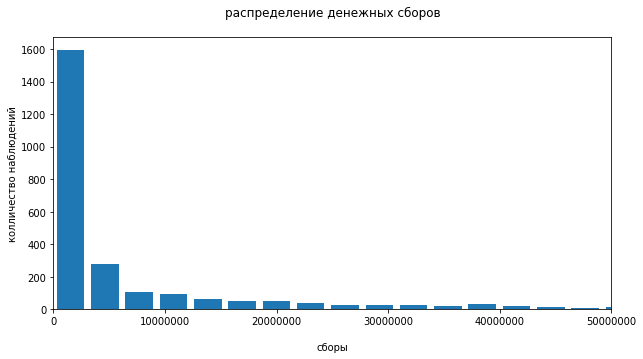

In [167]:
# гистограмма
plt.figure(figsize = (10,5))
plt.hist(data['box_office'], bins = 1000, rwidth = 0.8);
plt.xlabel('\n' 'сборы')
plt.ylabel('колличество наблюдений')
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlim(0, 50000000)
plt.title('распределение денежных сборов' '\n');

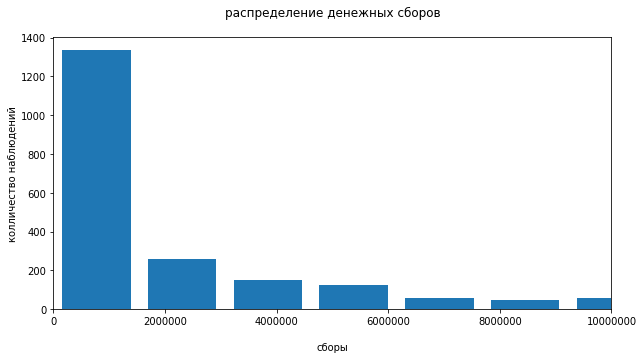

In [168]:
# гистограмма
plt.figure(figsize = (10,5))
plt.hist(data['box_office'], bins = 2000, rwidth = 0.8);
plt.xlabel('\n' 'сборы')
plt.ylabel('колличество наблюдений')
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlim(0, 10000000)
plt.title('распределение денежных сборов' '\n');

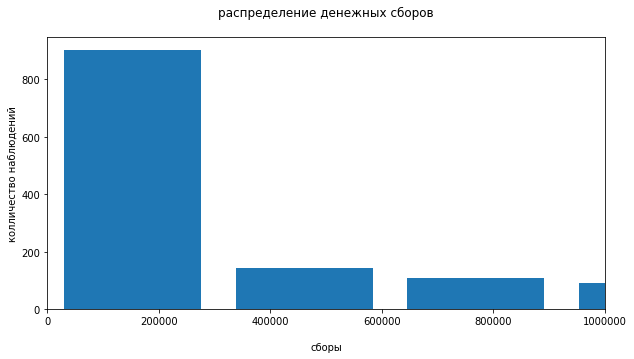

In [169]:
# гистограмма
plt.figure(figsize = (10,5))
plt.hist(data['box_office'], bins = 10000, rwidth = 0.8);
plt.xlabel('\n' 'сборы')
plt.ylabel('колличество наблюдений')
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlim(0, 1000000)
plt.title('распределение денежных сборов' '\n');

Посмотрю на статистику переменной box_office

In [170]:
# статистика
data['box_office'].describe().apply('{:,.0f}'.format)

count            3,015
mean        75,682,623
std        237,771,926
min                  0
25%            117,600
50%          2,430,003
75%         23,743,895
max      3,073,568,691
Name: box_office, dtype: object

Оказывается, что есть фильмы с нулевыми сборами, посмотрю на них поподробнее.

In [171]:
data.loc[data['box_office']==0]['type'].count()

24

У 24 фильмов нулевые сборы, это кажется ошибкой наблюдений, удалю такие наблюдения.

In [172]:
# удаляю наблюдения
data = data.query('box_office>0 or box_office.isna()')

# Шаг 2.6. Добавьте новые столбцы





- Создайте столбец с информацией о годе проката. Выделите год из даты премьеры фильма.

In [173]:
# добавляю год
data['year'] = data['show_start_date'].dt.year

- Создайте два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_2" aria-expanded="false" aria-controls="collapseHint_2">Подсказка</button>
        </div>
        <div id="collapseHint_2" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Чтобы создать такие столбцы, лучше всего использовать собственную функцию. Эту функцию можно применить к двум столбцам сразу. 
            </div>
        </div>
    </div>
</div>

In [174]:
# создаю функцию
def name(string):
    try:
        return string[0:string.find(',')]
    except:
        return string  

In [175]:
# создаю новые переменные
data['main_director'] = data['director'].apply(name)
data['main_genres'] = data['genres'].apply(name)

- Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка.

У нас нет наблюдения с нулевым буджетом, поэтому можно смело на него делить, аномалий не возникнет.

In [176]:
# создаю переменную
data['fraction'] = (data['refundable_support']+data['nonrefundable_support'])/data['budget']

In [177]:
# выводим статистику для fraction
data['fraction'].describe().apply('{:,.1f}'.format)

count    329.0
mean       0.5
std        0.2
min        0.0
25%        0.4
50%        0.6
75%        0.7
max        1.0
Name: fraction, dtype: object

Доля выглядит адекватно.

# Шаг 3. Проведите исследовательский анализ данных


- Посмотрите, сколько фильмов выходило в прокат каждый год. Обратите внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитайте, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.

In [178]:
# группирую по годам
data.groupby('year')['type'].count()

year
2010    753
2011    475
2012    511
2013    584
2014    723
2015    658
2016    770
2017    498
2018    864
2019    887
Name: type, dtype: int64

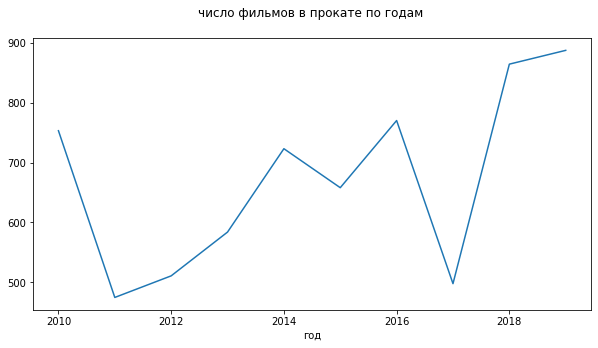

In [179]:
# график
data.groupby('year')['type'].count().plot(figsize = (10,5), xlabel = 'год', title = 'число фильмов в прокате по годам \n');

In [180]:
# доля фильмов с информацией о сборах
(data.groupby('year')['box_office'].count()/data.groupby('year')['type'].count()).apply('{:,.2f}'.format)

year
2010    0.11
2011    0.21
2012    0.22
2013    0.29
2014    0.35
2015    0.65
2016    0.65
2017    0.71
2018    0.55
2019    0.59
dtype: object

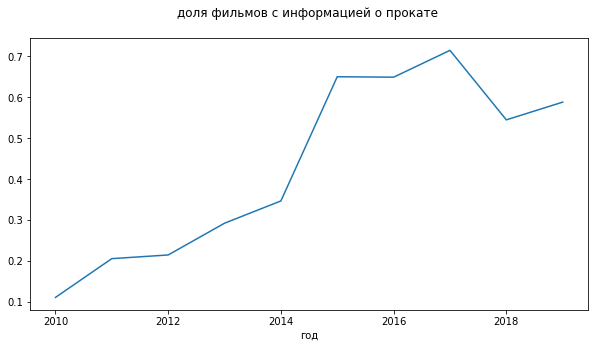

In [181]:
# график 
(data.groupby('year')['box_office']
 .count()/data.groupby('year')['type'].
 count()).plot(figsize = (10,5), xlabel = 'год', title = 'доля фильмов с информацией о прокате \n');

Из первого графика видно, что динамика выхода в прокат у фильмов была очень нелинейной: в 2011 и 2017 годах были провалы. Теперь посмотрим на сумму сборов.

- Изучите, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?

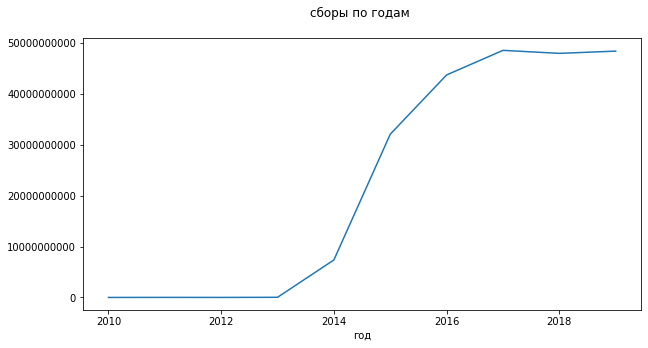

In [182]:
# график
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.plot(data.groupby('year')['box_office'].sum())
ax.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('год')
plt.title('сборы по годам \n')
plt.show()

На графике видно, что в 2010 - 2013 года практически одинаково минимальны, в то время как 2017 - 2019 года максимальны по сборам. Посмотрим на точные цифры.

In [183]:
# сумма по годам
pd.DataFrame(data.groupby('year')['box_office'].sum().sort_values()).style.background_gradient('coolwarm').format('{:,.0f}')

,box_office
year,
2010,"2,374,340"
2012,"6,420,761"
2011,"13,944,390"
2013,"29,768,531"
2014,"7,372,598,572"
2015,"32,084,649,858"
2016,"43,731,444,689"
2018,"47,970,952,311"
2019,"48,409,400,347"


Лидером по прокату оказался 2017 год, а самым минимальным - 2010.

- С помощью сводной таблицы посчитайте среднюю и медианную сумму сборов для каждого года.

In [184]:
# строим сводную таблицу
pd.pivot_table(data, values = 'box_office', index = 'year', aggfunc = ['mean', 'median']).style.format('{:,.0f}')

,mean,median
,box_office,box_office
year,,
2010,"28,266","2,085"
2011,"142,290","3,042"
2012,"58,371","6,838"
2013,"174,085","3,880"
2014,"29,372,903","28,150"
2015,"74,964,135","4,398,304"
2016,"87,462,889","3,650,261"
2017,"136,408,860","10,177,834"


Из сводной таблицы видно, как сильно отличаются средние и медианные сборы для каждого года. Это значит, что распределение сборов для каждого года очень сильно скошенное. В таком случае медиана будет более правильным показателем для использования.

- Определите, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? Если да, предположите, с чем это может быть связано.

Для начала сгруппируем данные по ограничениям и посмотрим на медианные сборы. 

In [185]:
# группировка
data.groupby('age_restriction')['box_office'].median().apply('{:,.0f}'.format)

age_restriction
«0+» - для любой зрительской аудитории       96,846
«12+» - для детей старше 12 лет             910,831
«16+» - для детей старше 16 лет           1,774,270
«18+» - запрещено для детей               5,124,405
«6+» - для детей старше 6 лет             6,252,884
Name: box_office, dtype: object

Любопытно, что наибольшие медианные сборы у фильмов с ограничение 6+, следующая категория у 18+, остальные сильно отстают.
Теперь посмотрим на срезу по годам.

In [186]:
# сводная таблица
(
    pd
    .pivot_table(data, values = 'box_office', index = ['year', 'age_restriction'], aggfunc = 'median')
    .style.background_gradient('coolwarm').format('{:,.0f}')
)

Из таблицы видно, что по годам влияние возрастных ограничений было очень разным - в ранние годы в выборке, когда сборы были очень низкими, наибольшие медианные сборы приходились на фильмы 0+. В более позние годы, когда сборы по фильмам были большими, наибольшие медианные сборы стали проиходиться на 6+. В частности, самый большой медианные сбор наблюдается у фильмов 6+ в 2017, из любопытства посмотрим на этот год.

In [187]:
# срез
(
    data
    .query('year == 2017 and age_restriction == "«6+» - для детей старше 6 лет"')
    .sort_values(by = 'box_office', ascending = False)
)

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year,main_director,main_genres,fraction
4984,Движение вверх,111011817,2017-12-21 00:12:00,Художественный,"ооо ""студия ""тритэ"" никиты михалкова""",Россия,А.Мегердичев,"Л.Верещагин, А.Златопольский, Н.Михалков, ООО ...",«6+» - для детей старше 6 лет,0.0,400000000.0,590192191.0,Фонд кино,7.5,"спорт,драма",2.779686e+09,2017,А.Мегердиче,спорт,0.677745
3451,Гадкий я 3,124001617,2017-06-15 00:12:00,Анимационный,"иллюминейшен интертейнмент, юниверсал пикчерз",США,"Кайл Балда, Эрик Гуильон, Пьер Коффан","Кристофер Меледандри, Джанет Хили, Бретт Хоффман",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.3,"мультфильм,фантастика,фэнтези",1.390393e+09,2017,Кайл Балда,мультфильм,NaN
2950,Босс-Молокосос,124000317,2017-02-09 00:12:00,Анимационный,дримуоркс анимейшн,США,Том МакГрат,Рэмси Энн Наито,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.5,"мультфильм,комедия,приключения",1.376727e+09,2017,Том МакГра,мультфильм,NaN
3347,Зверопой,124000217,2017-02-03 00:12:00,Анимационный,"дентсю, фьюджи телевижн нетворк интертейнмент,...",США - Великобритания - Япония,"Гарт Дженнингс, Кристоф Лоурделет","Игорь Хайт, Джанет Хили, Бретт Хоффман",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.3,"мультфильм,мюзикл,комедия",8.866141e+08,2017,Гарт Дженнингс,мультфильм,NaN
4972,Ёлки Новые,111011617,2017-12-21 00:12:00,Художественный,"ооо ""таббак""",Россия,"Д.Киселев, А.Першин (Ж.Крыжовников), А.Карпило...","Т.Бекмамбетов, Г.Стрижевская",«6+» - для детей старше 6 лет,50000000.0,50000000.0,174381922.0,Фонд кино,5.8,"комедия,мелодрама",8.554511e+08,2017,Д.Киселев,комедия,0.573454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4923,Секретная миссия,111008817,2017-11-22 00:12:00,Художественный,"киностудия ""мосфильм""",СССР,М.Ромм,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,5.8,"драма,военный",NaN,2017,М.Ром,драма,NaN
4924,Семь нянек,111008917,2017-11-22 00:12:00,Художественный,"киностудия ""мосфильм""",СССР,Р.Быков,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.7,комедия,NaN,2017,Р.Быко,комеди,NaN
4928,Служили два товарища,111009317,2017-11-22 00:12:00,Художественный,"киностудия ""мосфильм""",СССР,Е.Карелов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,8.2,"драма,комедия,военный",NaN,2017,Е.Карело,драма,NaN
4945,Суета сует,111010317,2017-11-22 00:12:00,Художественный,"киностудия ""мосфильм""",СССР,А.Сурикова,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.7,комедия,NaN,2017,А.Суриков,комеди,NaN


Действительно, 2017 был богат на успешные мультики и фильмы с рейтингом 6+. 

Чтобы сделать окончательные выводы про влияние рейтингов на сборы, проведём эконометрический анализ.

In [189]:
# создаем функцию
def age_0(age):
    try:
        if '0' in age:
            return 1
        else:
            return 0
    except:
        pass
        
def age_6(age):
    try:
        if '6' in age:
            return 1
        else:
            return 0
    except:
        pass

def age_12(age):
    try:
        if '12' in age:
            return 1
        else:
            return 0
    except:
        pass
    
def age_16(age):
    try:
        if '16' in age:
            return 1
        else:
            return 0
    except:
        pass
        
def age_18(age):
    try:
        if '18' in age:
            return 1
        else:
            return 0
    except:
        pass

In [190]:
# создаю переменные и перекрестные перемножения
data['age_0'] = data['age_restriction'].apply(age_0)
data['age_6'] = data['age_restriction'].apply(age_6)
data['age_12'] = data['age_restriction'].apply(age_12)
data['age_16'] = data['age_restriction'].apply(age_16)
data['age_18'] = data['age_restriction'].apply(age_18)
data['year_age_0'] = data['year']*data['age_0']
data['year_age_6'] = data['year']*data['age_6']
data['year_age_12'] = data['year']*data['age_12']
data['year_age_16'] = data['year']*data['age_16']
data['year_age_18'] = data['year']*data['age_18']

In [191]:
# создаю датасет 
d = data.query('box_office.notna()')

In [192]:
# оцениваю линейную регрессию
x = (d[['year', 'age_0', 'age_6', 'age_12', 'age_16', 'age_18', 'year_age_0', 'year_age_6', 
           'year_age_12', 'year_age_16', 'year_age_18']].astype(float))
y = d['box_office'].astype(float)
x2 = sm.add_constant(x)
reg = sm.OLS(y,x2).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     16.77
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           6.41e-30
Time:                        21:57:01   Log-Likelihood:                -61859.
No. Observations:                2991   AIC:                         1.237e+05
Df Residuals:                    2980   BIC:                         1.238e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.646e+12   2.89e+13     -0.230      

Хоть качественно мы и увидели какие-то закономерности по влиянию возрастных ограничений на сумму сборов, но статистический анализ никаких значимых влияний не обнаружил.

# Шаг 4. Исследуйте фильмы, которые получили государственную поддержку

На этом этапе нет конкретных инструкций и заданий — поищите интересные закономерности в данных. Посмотрите, сколько выделяют средств на поддержку кино. Проверьте, хорошо ли окупаются такие фильмы, какой у них рейтинг.

Для начала посмотрим, какой процент российских фильмов получал финансовую помощь.

In [193]:
# считаем процент
(
    data.loc[(data['refundable_support']>0) | (data['nonrefundable_support']>0)].groupby('year')['type'].count()/
    data.loc[(data['refundable_support'].notna()) & (data['nonrefundable_support'].notna())].groupby('year')['type'].count()
)


year
2013    0.025316
2014    0.115108
2015    0.423645
2016    0.314433
2017    0.308271
2018    0.118143
2019    0.205521
Name: type, dtype: float64

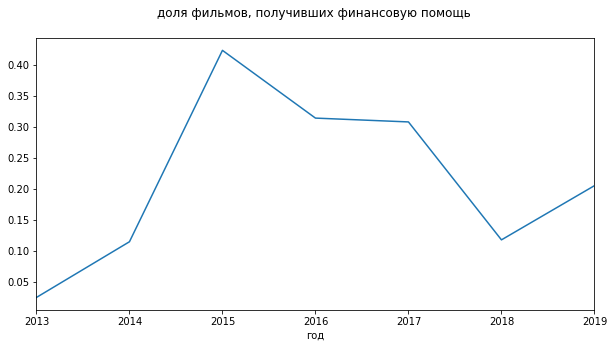

In [194]:
# график
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.plot((
    data.loc[(data['refundable_support']>0) | (data['nonrefundable_support']>0)].groupby('year')['type'].count()/
    data.loc[(data['refundable_support'].notna()) & (data['nonrefundable_support'].notna())].groupby('year')['type'].count()
))
plt.xlim(2013, 2019)
plt.xlabel('год')
plt.title('доля фильмов, получивших финансовую помощь \n')
plt.show()

Процент фильмов, получавших какую-то финансовую помощь от государства начал был на максимуме в 2015 году когда больше 40% фильмов её получали, потом начал снова спадать.

Посмотрим на распределение невозвратных и возвратных средств.

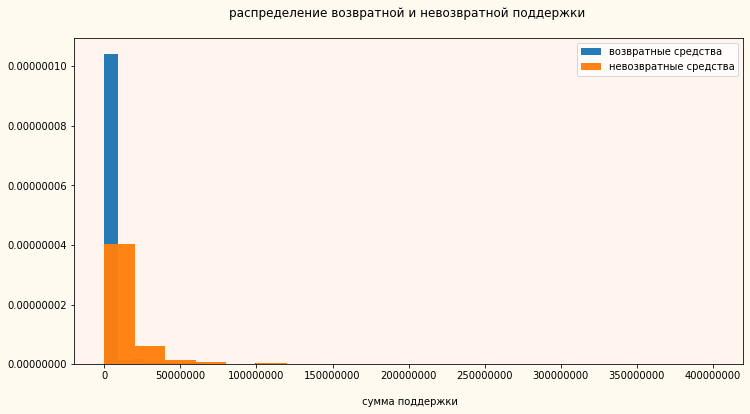

In [195]:
# Строю гистограмму
fig, ax = plt.subplots()
plt.hist(data['refundable_support'], bins = 20, alpha=0.97, label = 'возвратные средства', density = True)
plt.hist(data['nonrefundable_support'], bins = 20, alpha=0.97, label = 'невозвратные средства', density = True)
plt.legend(loc = 'upper right')
plt.xlabel('\n сумма поддержки')
fig.set_figwidth(12)    
fig.set_figheight(6)    
plt.title('распределение возвратной и невозвратной поддержки \n')
plt.ticklabel_format(useOffset=False, style='plain')
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')
plt.show()

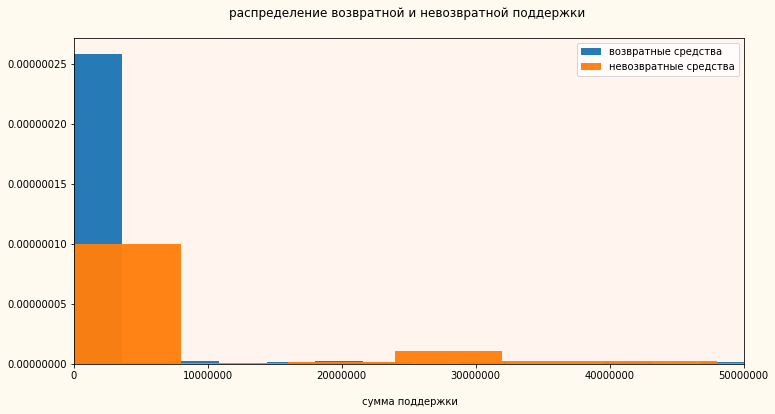

In [196]:
# Строю гистограмму
fig, ax = plt.subplots()
plt.hist(data['refundable_support'], bins = 50, alpha=0.97, label = 'возвратные средства', density = True)
plt.hist(data['nonrefundable_support'], bins = 50, alpha=0.97, label = 'невозвратные средства', density = True)
plt.legend(loc = 'upper right')
plt.xlabel('\n сумма поддержки')
plt.title('распределение возвратной и невозвратной поддержки \n')
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlim(0, 50000000)
fig.set_figwidth(12)    
fig.set_figheight(6)    
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')
plt.show()


Из первой гистограммы видно, что у нас есть выборосы - какие-то фильмы, которые получили на порядок больше средств, чем остальные.
Из второй гистограммы видно, что невозвратная поддержка часто оказывается на большую сумму (немного неожиданно).

Посмотрим на выбросы в наблюдениях.

In [197]:
# квантили
print(data.query('refundable_support>0')['refundable_support'].quantile([0.0012, 0.01, .5, .99, .9988]).apply('{:,.0f}'.format))
print()
print((
    data
    .query('nonrefundable_support>0')['nonrefundable_support'].quantile([0.0012, 0.01, .5, .99, .9988]).apply('{:,.0f}'.format))
)

0.0012      3,694,400
0.0100      5,000,000
0.5000     25,000,000
0.9900    147,200,000
0.9988    176,112,000
Name: refundable_support, dtype: object

0.0012      3,650,760
0.0100      5,000,000
0.5000     30,000,000
0.9900    300,000,000
0.9988    400,000,000
Name: nonrefundable_support, dtype: object


Среди тех, кто получал невозвратную помощь, медиана в помощи была в 30 млн.р., но 0.12% фильмов получили невозвратную помощь более чем в 10 раз больше.

Посмотрим, что это за лидеры по невозвратной поддержке.

In [198]:
data.query('nonrefundable_support>=400000000')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,age_0,age_6,age_12,age_16,age_18,year_age_0,year_age_6,year_age_12,year_age_16,year_age_18
4984,Движение вверх,111011817,2017-12-21 00:12:00,Художественный,"ооо ""студия ""тритэ"" никиты михалкова""",Россия,А.Мегердичев,"Л.Верещагин, А.Златопольский, Н.Михалков, ООО ...",«6+» - для детей старше 6 лет,0.0,...,0,1,0,0,0,0,2017,0,0,0
6726,Союз спасения,111022019,2019-12-26 00:12:00,Художественный,"зао ""дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«12+» - для детей старше 12 лет,100000000.0,...,0,0,1,0,0,0,0,2019,0,0


Посмотрим на возвратную и невозвратную помощь по годам

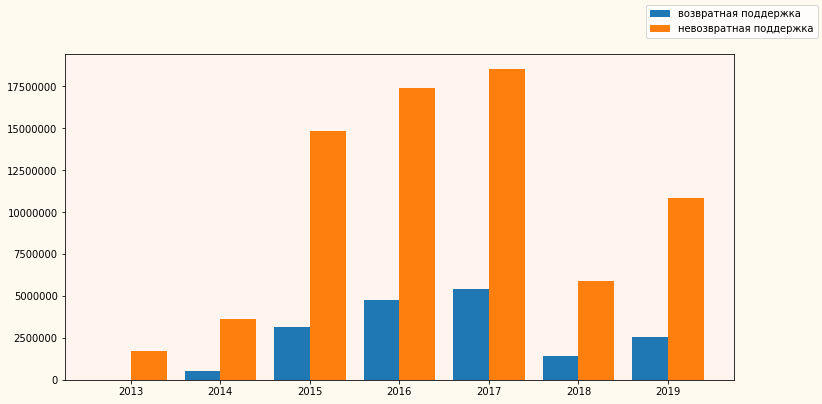

In [199]:
# столбчатая диаграмма
fig, ax = plt.subplots()
x1 = data.query('refundable_support.notna()').groupby('year')['refundable_support'].mean().index - 0.2
x2 = data.query('nonrefundable_support.notna()').groupby('year')['nonrefundable_support'].mean().index+0.2
y1 = data.query('refundable_support.notna()').groupby('year')['refundable_support'].mean()
y2 = data.query('nonrefundable_support.notna()').groupby('year')['nonrefundable_support'].mean()


ax.bar(x1, y1, width = 0.4, label = 'возвратная поддержка')
ax.bar(x2, y2, width = 0.4, label = 'невозвратная поддержка')
fig.legend(loc = 'upper right')
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_facecolor('seashell')
fig.set_figwidth(12)    
fig.set_figheight(6)    
fig.set_facecolor('floralwhite')

plt.show()

Посмотрю теперь на общие траты государства по годам.

Из диаграммы мы видимо, что во-первых, невозвратная поддержка всегда превышала возвратную. Во-вторых, есть нелинейная динамика - был существенный рост финансовой поддержки в 2015-2017 годы. 

In [200]:
# общие траты по годам
data['total_support'] = data['refundable_support']+data['nonrefundable_support']
data.groupby('year')['total_support'].sum().apply('{:,.0f}'.format)

year
2010                0
2011                0
2012                0
2013      134,347,945
2014      572,002,299
2015    3,656,241,459
2016    4,303,155,482
2017    3,183,971,662
2018    3,446,969,465
2019    4,349,000,000
Name: total_support, dtype: object

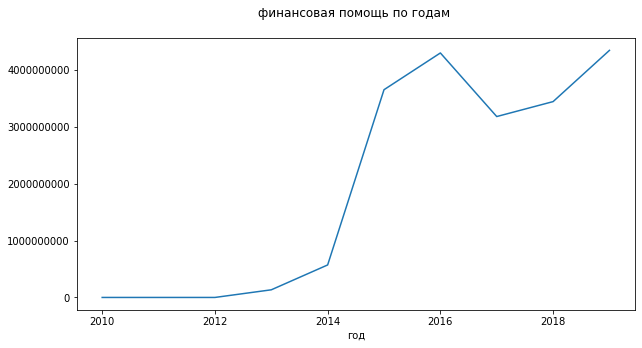

In [201]:
# график
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.plot(data.groupby('year')['total_support'].sum())
ax.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('год')
plt.title('финансовая помощь по годам \n')
plt.show()

Виден резкий рост расходов на кино, начиная с 2014 года. Похоже, что начиная с 2014 года у государства появилось желание вкладывать деньги в российское кино.

Теперь посмотрим, как связана финансовая поддерка с успешностью фильма (сборами и рейтингом). Посмотрим как свяазана финансовая поддержка с бюджетом, сборами и рейтингом фильма.

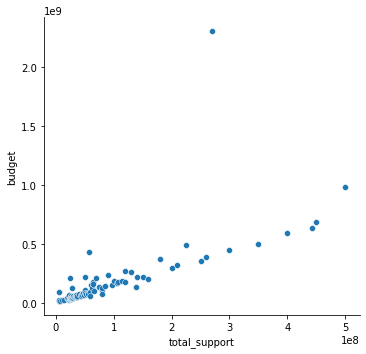

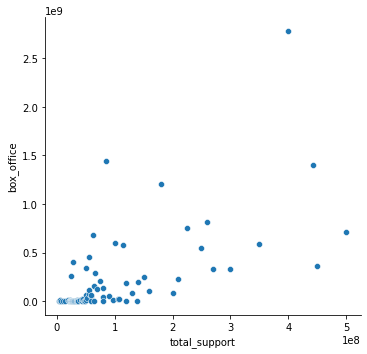

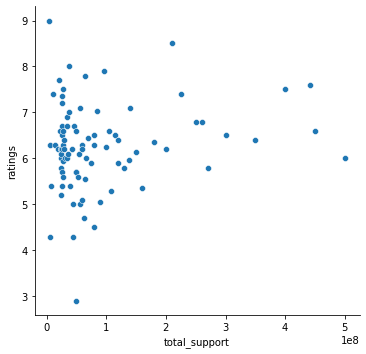

In [202]:
# строим scatter plot для медианных значений
support_pivot_area = (data
                      .query('budget.notna() and box_office.notna()')
                      .pivot_table(index = 'total_support', values =(['budget', 'box_office', 'ratings']), aggfunc = 'median')
                     )
support_pivot_area = support_pivot_area.reset_index()
for row in ['budget', 'box_office', 'ratings']:
    sns.relplot(data = support_pivot_area, x = 'total_support', y = row, kind = 'scatter')

На диаграммах видно, что финансовая помощь очень сильно связана с медианным бюджетом, видна практически линейная зависимость, но зависимость между помощью и сборами либо же рейтингом уже не так очевидна.

In [203]:
# считаем корреляция
data['total_support'].corr(data['budget'])

0.7169390947386073

Действительно очень сильная корреляция.

Оценим теперь эту взаимосвязь статистически.

In [204]:
# оцениваю линейную регрессию
d = data.query('box_office.notna() and budget.notna()')
x = (d[['total_support', 'budget']].astype(float))
y = d['box_office'].astype(float)
x2 = sm.add_constant(x)
reg = sm.OLS(y,x2).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     49.39
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           2.27e-19
Time:                        21:58:17   Log-Likelihood:                -6608.2
No. Observations:                 316   AIC:                         1.322e+04
Df Residuals:                     313   BIC:                         1.323e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.136e+07    2.2e+07     -0.516

Регрессия показала, что действительно финансовая помощь очень сильно влияет на сборы фильма (на каждый рубль помощи сборы в среднем растут на 2.16 рублей). При этом бюджет значимо не влияет на сборы скорее всего из-за коллинеарности с финансовой помощь. Стоит ещё отметить, что фильмы с большой помощью пользуются и другими привилегиями административного ресурса, которые не учитываются в модели - например, рекламой на федеральных каналах, а реклама увеличивает сборы. 

Посмотрю, есть ли разница между возвратной и невозвратной помощью.

In [205]:
# оцениваю линейную регрессию
d = data.query('box_office.notna() and budget.notna()')
x = (d[['refundable_support','nonrefundable_support', 'budget']].astype(float))
y = d['box_office'].astype(float)
x2 = sm.add_constant(x)
reg = sm.OLS(y,x2).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     32.82
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           1.82e-18
Time:                        21:58:23   Log-Likelihood:                -6608.2
No. Observations:                 316   AIC:                         1.322e+04
Df Residuals:                     312   BIC:                         1.324e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.136e+

Нет разницы между возвратной и невозвратной помощью - обе переменные значимо увеличивают сборы фильма.

Теперь посмотрим на влияние на рейтинг.

In [206]:
# оцениваю линейную регрессию
d = data.query('box_office.notna() and budget.notna()')
x = (d[['refundable_support','nonrefundable_support', 'budget']].astype(float))
y = d['ratings'].astype(float)
x2 = sm.add_constant(x)
reg = sm.OLS(y,x2).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                ratings   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.783
Date:                Tue, 07 Mar 2023   Prob (F-statistic):             0.0411
Time:                        21:58:29   Log-Likelihood:                -483.99
No. Observations:                 316   AIC:                             976.0
Df Residuals:                     312   BIC:                             991.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.88

Интересно, что хоть на успешность фильма финансовая помощь влияет, а вот на качестве фильма она практически никак не отображается. Есть статистически значимое влияние у невозвратной помощи - но экономического значения он не приносит, потому что является очень маленьким. 
Картина будет ещё более ясная, если не разделять на подвиды поддержки.

In [207]:
# оцениваю линейную регрессию
d = data.query('box_office.notna() and budget.notna()')
x = (d[['total_support', 'budget']].astype(float))
y = d['ratings'].astype(float)
x2 = sm.add_constant(x)
reg = sm.OLS(y,x2).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                ratings   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.451
Date:                Tue, 07 Mar 2023   Prob (F-statistic):             0.0879
Time:                        21:58:40   Log-Likelihood:                -485.71
No. Observations:                 316   AIC:                             977.4
Df Residuals:                     313   BIC:                             988.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.8981      0.085     69.502

Ни деньги ни финансовая помощь не могут значимо улучшить рейтинг российского кино.

# Шаг 5. Напишите общий вывод

В данном проекте я изучила данные из двух источников - из Кинопоиска и от Министерства Культуры. 

Я объединила данные из этих источников в один датасет. Я поменяла типы у даты и у рейтинга и унифицировала вид рейтинга.
В данных были пропуски - в некоторых переменных пропусков было очень много - например в данных о финансовой поддержке, скорее всего потому, что данные были доступны лишь по тем фильмам, которую поддержку получили и лишь в определённых годах. В некоторых переменных пропусков было очень мало - где было возможно я заполнила пропуски руками, остальные такие немногие наблюдения удалила. 
В данных про рейтинг фильма пропусков было не очень много, но при этом и не очень мало и такие данные не хотелось терять. Я волспользовалась алгоритмом knn и заполнила пропуски средними из схожих наблюдений по уровню сборов. 
Последним этапом предобработки данных я обнаружила, что есть российские фильмы, вышедшие после 2013 года (дата начала данных о финансовой помощи) с пропусками в переменных о помощи. Это означало, что они её не получали и я заменила пропуски нулями.

Я создала новые переменные с годом выхода фильма, выделила главного режиссера и жанр и посчитала долю, которую занимала финансовая поддержка в бюджете фильма. 

Ислледование динамики проката показало, что она была очень нелинейной и вслед за годами с большим колличеством вышедших фильмов бывали года с очень небольшим прокатом - особенно это заметно в 2011 и в 2017. 

При этом анализ сборов в кинотеатрах показал экспоненциальный рост сборов в районе 2014/2015 годов с максимальным значением сборов в 2017 году. 

При этом сравнение среднего и медианы показало, что распределение сборов сильно смещённое - медиана и среднее отличались в разы. Поэтому в случаях, где это было возможно, я использовала медианное значение в дальнейшем исследовании.

Далее я рассмотрела влияние возрастного ограничения на сборы. Если в ранние годы с небольшими сборами, наибольшие медианные сборы приходились на фильмы 0+, то в годы с большими сборами наибольшее значение было у фильмов 6+. Дальнейший статистический анализ показал, что эти различия тем не менее не являются статистически значимыми. 

В заключительной части проекта я исследовала влияния финансовой помощи на успешность и рейтинг российских фильмов. Анализ показал, что доля фильмов, получающих финансовую поддержку государства менялась нелинейно и достигла максимума в 2015 году, когда более 40% выходивших фильмов получили государственную денежную поддержку. При этом распределение возвратной и невозвратной помощи показало, что невозвратная помощь чаще давалась в более крупных размерах. Общие траты государства на финансовую поддержку российских фильмов начинает резко расти после 2014 года. 
Финансовая поддержка очень сильно коррелирует с бюджетом фильма и оказывает значимое влияние на сборы фильмов - на 1 рубль помощи сборы растут в среднем на 2.16 рублей. Но к данному выводу надо относиться с осторожностью, потому что финансовая помощь так же скоррелирована с доступом к рекламе и продвижению фильмов на федеральных каналах, что сильно связано с кассовым успехом фильма, но учесть в регрессии мы это не можем.
Тем не менее ни бюджет фильма ни финансовая поддержка не оказывают значимого влияния на рейтинг фильма. Видимо для улучшения качества российского кинематографа нужно что-то помимо денег.
